Online learning is a machine learning technique that allows a model to be updated with new data as it becomes available without the need to retrain the model from scratch.

To implement online learning for an anomaly detection model, the model needs to be designed to handle incremental updates. One way to achieve this is by using techniques such as stochastic gradient descent, which allows the model to be updated incrementally based on the new data.

The process for online learning in anomaly detection typically involves the following steps:

Collect new data: As new data becomes available, it can be collected and added to the existing data set.

Update the model: The model can be updated using the new data while preserving the knowledge gained from previous training.

Test the model: The updated model should be tested using new data to ensure that it is still able to accurately detect anomalies.

Repeat: The process can be repeated as new data becomes available, allowing the model to continuously learn and adapt to changing conditions.

Overall, online learning provides a way to continuously improve the performance of an anomaly detection model over time, as new data becomes available.

In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
import os
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [27]:
class AnomalyDetector:
    def __init__(self, n_components=1, covariance_type='full', k_threshold_std_dev=3):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.k_threshold_std_dev = k_threshold_std_dev
        self.gmm = None
        self.X = np.array([])

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the training data.
        """
        if self.gmm is None:
            self.gmm = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type)
            self.gmm.fit(X)
            self.X = X
        else:
            self.X = np.concatenate((self.X, X), axis=0)
            self.gmm.fit(self.X)
            
        # This tells the GMM to initialize the model parameters using the k-means algorithm, which can be more efficient than the default random initialization for large datasets

    def predict(self, X_test):
        """
        Predict whether the data is anomalous or not based on the GMM.
        """
        scores = self.gmm.score_samples(self.X)
        k = self.k_threshold_std_dev
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        threshold = mean_score - k * std_score
        is_anomaly = self.gmm.score_samples(X_test) < threshold
        return is_anomaly


In the modified code, the AnomalyDetector class has been updated to support online learning. The fit method now allows the model to be updated with new data, while the predict method returns the anomaly predictions based on the updated model.

To use the updated AnomalyDetector class, you would first create an instance of the class and fit it to your initial training data:

In [5]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/anomalous_data.csv')


In [6]:
train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [7]:
modules.AnomalyDetector.GaussianMixture(train_feature_dataframe=train_scaled, test_feature_dataframe=test_scaled)


anomalous


In [36]:
# TODO adjust sensitivity
anomaly_detector = AnomalyDetector(n_components=1, covariance_type='full', k_threshold_std_dev=3)


In [41]:
ct = 2
it = iter(train_scaled)
try:
    while True:
        if anomaly_detector.gmm is None:
            data = [next(it), next(it)] #if the model is being fit for the first time
        else :
            data = [next(it)]
            ct += 1
        anomaly_detector.fit(data)
        anomaly_predictions = anomaly_detector.predict(data)
        if any(anomaly_predictions):
            print(f'anomalous {ct}')
        else:
            # print('not anomalous')
            pass

except StopIteration:
    pass


anomalous 245
anomalous 287


These are the anomalies predicted whilst training on the data on the go

In [38]:
anomaly_scores = anomaly_detector.predict(train_scaled)

In [39]:
np.where(anomaly_scores == 1)[0]



array([116, 242, 284], dtype=int64)

These are predicted after the whole dataset was trained

Finally, you can use the predict method to get anomaly predictions for your test data:

In [40]:
anomaly_predictions = anomaly_detector.predict(test_scaled)
if anomaly_predictions:
    print('anomalous')
else:
    print('not anomalous')


anomalous


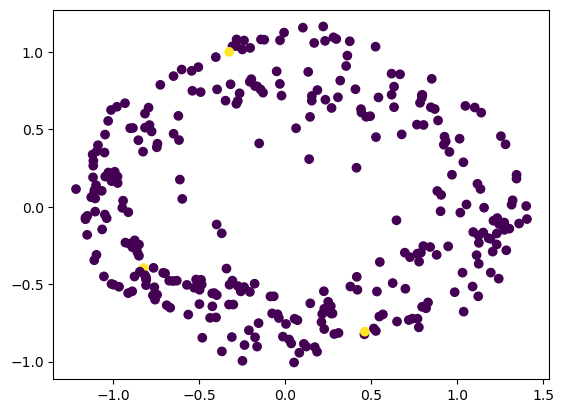

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()